# Using Machine Learning to Diagnose Malaria


Julia York



In [ ]:
#import tensorflow as tf #Import Tensorflow with alias tf

from tensorflow.keras import Sequential #Import Sequential model/API
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout #Import APIs that will be used in layer building
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array #Import image data augmentation class which enables images in the dataset to be edited
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers #Import optimizers that will help train the model
from tensorflow.keras.applications.resnet50 import preprocess_input

print(tf.__version__) #Verify the Tensorflow import by printing the version

In [2]:
#Importing other required APIs
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
#Path for downloaded Kaggle dataset
directory = "/home/julia/datasets/cell_images"

In [4]:
#Set image size
IMAGE_SIZE = [224, 224]

In [5]:
#Allow for rescaling all images to the same, desired range; split the dataset into an 80%/20% ratio between training data and validation data.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [6]:
#Creating separate datasets for training and for validation
train_set = train_datagen.flow_from_directory(directory='/home/julia/datasets/cell_images',
                                                   target_size = (224, 224),
                                                   class_mode = 'categorical',
                                                   batch_size = 32,
                                                   subset = 'training'
                                                  )

Found 22048 images belonging to 2 classes.


In [7]:
#Validation data set. 5510/27558 images belong to the validation training set.
validation_set = train_datagen.flow_from_directory(directory='/home/julia/datasets/cell_images',
                                                   target_size = (224, 224),
                                                   class_mode = 'categorical',
                                                   batch_size = 32,
                                                   subset = 'validation'
                                                  )

Found 5510 images belonging to 2 classes.


In [8]:
#Labels the images in train_set as 0 or 1; where 0=parasitized and 1=uninfected.
train_set.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
#Labels the images in validation_set as 0 or 1.
validation_set.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [10]:
#The model
model = Sequential() #Sequential model allowing for building own layers.

#Layer 1
model.add(Conv2D(16, (3,3), input_shape = (224, 224, 3), padding='same', activation='relu')) #Convolution layer that extracts features from the image.
model.add(MaxPool2D(2,2)) #Lets CNN recognize the image in any shape, size, or orientation.
model.add(Dropout(0.2)) #Helps CNN from overfitting; it is set to 20% here.

#Layer 2
model.add(Conv2D(32, (3,3), padding='same', activation='relu')) #ReLU (rectifier function) in all layers adds non-linearity to the images.
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

#Layer 3
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#Layer 4
model.add(Dense(2, activation='softmax')) #Dense layer helps with making predictions; softmax for probabilities.

In [11]:
#Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [12]:
#Model compilation in order to move on to training
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])

In [13]:
#Model training using model.fit
history = model.fit_generator(generator=train_set,
                             steps_per_epoch = len(train_set),
                             epochs = 5,
                             validation_data = validation_set,
                             validation_steps = len(validation_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
689/689 [==============================] - 379s 550ms/step - loss: 0.6326 - accuracy: 0.7120 - val_loss: 0.3737 - val_accuracy: 0.9185
Epoch 2/5
689/689 [==============================] - 369s 536ms/step - loss: 0.2747 - accuracy: 0.9238 - val_loss: 0.2365 - val_accuracy: 0.9339
Epoch 3/5
689/689 [==============================] - 370s 536ms/step - loss: 0.2370 - accuracy: 0.9333 - val_loss: 0.2678 - val_accuracy: 0.9189
Epoch 4/5
689/689 [==============================] - 371s 539ms/step - loss: 0.2235 - accuracy: 0.9353 - val_loss: 0.2141 - val_accuracy: 0.9298
Epoch 5/5
689/689 [==============================] - 370s 536ms/step - loss: 0.2163 - accuracy: 0.9348 - val_loss: 0.1972 - val_accuracy: 0.9348


In [14]:
#Summary of the model training per epoch.
history.history

{'loss': [0.6326104998588562,
  0.2746756672859192,
  0.23698000609874725,
  0.2234809547662735,
  0.2163231372833252],
 'accuracy': [0.7119920253753662,
  0.9237572550773621,
  0.9332819581031799,
  0.9353229403495789,
  0.9348240494728088],
 'val_loss': [0.37367990612983704,
  0.2365242838859558,
  0.2678022086620331,
  0.21406741440296173,
  0.19717781245708466],
 'val_accuracy': [0.9185118079185486,
  0.9339382648468018,
  0.9188748002052307,
  0.9297640919685364,
  0.9348457455635071]}

In [15]:
#Plotting to see if there is over-fitting or under-fitting in the model.
def plot_learningCurve(history, epoch):
    #Plot training and validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    #Plot training and validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
#Code adapted from laxmimerit here: https://github.com/laxmimerit/Malaria-Classification-Using-CNN

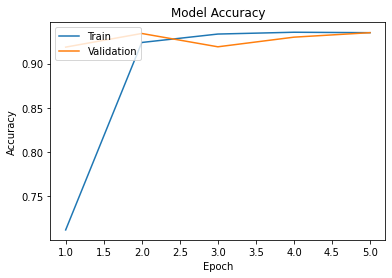

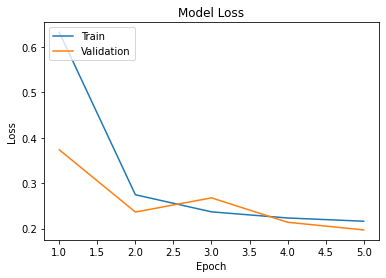

In [16]:
#Visualization of the plots; history is the model, and 5 is number of epochs
plot_learningCurve(history, 5)

In [17]:
#Save model as a file
model.save('model_sequential.h5')

# References

Guru99, (n.d.). Tensorflow Image Classification: CNN (Convolutional Neural Network). Retrieved from: https://www.guru99.com/convnet-tensorflow-image-classification.html

KGP Talkie, (2019, Sept 6). TensorFlow 2.0 Tutorial for Beginners 15 - Malaria Parasite Detection Using CNN. YouTube. Retrieved from: https://www.youtube.com/watch?v=Jdagdil0FIw&t=785s

Laxmimerit, (2019). Malaria-Classification-Using-CNN. Retrieved from: https://github.com/laxmimerit/Malaria-Classification-Using-CNN

MissingLink.ai, (n.d.a). Using the Keras Flatten Operation in CNN Models with Code Examples. Retrieved from: https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/

MissingLink.ai, (n.d.b). TensorFlow Conv2D Layers: A Practical Guide. Retrieved from: https://missinglink.ai/guides/tensorflow/tensorflow-conv2d-layers-practical-guide/

Naik, K. (2020, July 9). Live- Implementation Of Malaria Disease Using Deep Learning End To End Projects With Deployment. YouTube. Retrieved from: https://www.youtube.com/watch?v=H-bcnHE6Mes&t=5127s

Sarin, S. (2019). Exploring Data Augmentation with Keras and TensorFlow. Retrieved from: https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

SuperDataScience Team, (2018). The Ultimate Guide to Convolutional Neural Networks (CNN). Retrieved from: https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn

Tensorflow, (2021a). tf.keras.Sequential. Retrieved from: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Tensorflow, (2021b). Introduction to modules, layers, and models. Retrieved from: https://www.tensorflow.org/guide/intro_to_modules